In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pde
import os

ROOT = "."
SIM = 0 # choose
FIGURES_FOLDER = ROOT + f"/Figures/sim{SIM}/"
SIM_FOLDER = ROOT + f"/Simulations/sim{SIM}/"

if not os.path.exists(FIGURES_FOLDER):
    os.mkdir(FIGURES_FOLDER)
if not os.path.exists(SIM_FOLDER):
    os.mkdir(SIM_FOLDER)

C:\Users\nicol\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
def G(rho, p, P):
  return p*(1-rho/P)

# 1D parameter derivation:
# delta^2 / (1*tau) -> D for delta, tau -> 0
# Du = theta_u * D
# Di = theta_i * D

delta = 0.1 # mm
tau = 0.2 # h
D = delta**2/(4*tau)
Du = Di = 1.88e-4 # mm^2/h
theta_u = Du/D
theta_i = Di/D
beta = 1.02e-1 # h-1
p = 1.87e-2 # h-1
q = 4.17e-2 # h-1
P = K = 1e4 # 1/mm^2
c_max = int(K*delta)
Ru = 2.6 # mm
Ri = 1 # mm
pop_unit = 1

In [6]:
def initialize_mesh(delta, Ru, Ri, c_max):
  initial_u = int(.9*K)
  initial_i = int(.1*K)
  size = int(1/delta * 10 * 2)
  domain = np.zeros((2, size, size),dtype='uint16')
  for i in range(size):
    total_line = 0
    for j in range(size):
      if ((i-size/2)*delta)**2 + ((j-size/2)*delta)**2 <= (Ru)**2:
        domain[0][i][j] = initial_u
      if ((i-size/2)*delta)**2 + ((j-size/2)*delta)**2 <= (Ri)**2:
        domain[1][i][j] = initial_i
  return domain

domain = initialize_mesh(delta, Ru, Ri, c_max)

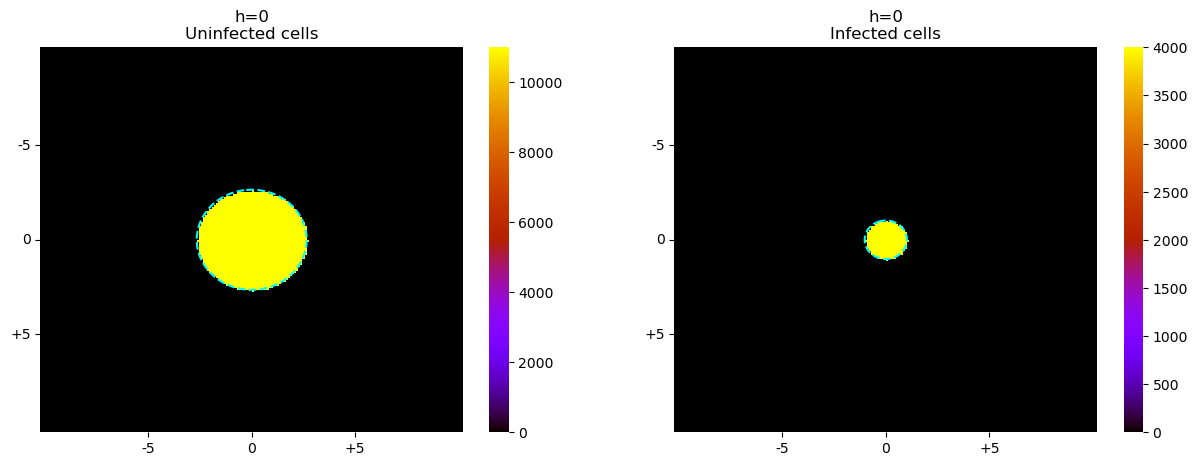

In [9]:
# define functions and parameters to save and plot results

def Circle(x, y, center):
  return (x-center)**2+(y-center)**2

size = int(1/delta * 10 * 2)
xx = np.linspace(0, size, size)
yy = np.linspace(0, size, size)
X, Y = np.meshgrid(xx,yy)
Z = Circle(X, Y, size//2)
ticks = [size//2 - 5//delta, size//2, size//2 + 5//delta]


def plot_domain(domain, h):
  radius_u = (Ru + h*2*np.sqrt(Du*p))/delta
  radius_i = (Ri + h*2*np.sqrt(Di*(beta-q)))/delta
  plt.figure(figsize=(15, 5))

  # plot U
  plt.subplot(1, 2, 1)
  ax1 = sns.heatmap(np.divide(domain[0],delta**2),vmin=0,vmax=K*1.1,cmap="gnuplot")
  ax1.set_xticks(ticks)
  ax1.set_xticklabels(["-5","0","+5"],rotation=0)
  ax1.set_yticks(ticks)
  ax1.set_yticklabels(["-5","0","+5"],rotation=0)
  ax1.title.set_text(f"h={h}\nUninfected cells")
  ax1.contour(X,Y,Z,[radius_u**2],colors=["cyan"],linestyles=["dashed"])

  # plot I
  plt.subplot(1, 2, 2)
  ax2 = sns.heatmap(np.divide(domain[1],delta**2),vmin=0,vmax=K*.4,cmap="gnuplot")
  ax2.set_xticks(ticks)
  ax2.set_xticklabels(["-5","0","+5"],rotation=0)
  ax2.set_yticks(ticks)
  ax2.set_yticklabels(["-5","0","+5"],rotation=0)
  ax2.title.set_text(f"h={h}\nInfected cells")
  ax2.contour(X,Y,Z,[radius_i**2],colors=["cyan"],linestyles=["dashed"])

  # save and plot figure
  # plt.savefig(f"{FIGURES_FOLDER}/random_walk_sim{SIM}_h{h}.png", format='png', dpi=200)
  plt.show()

plot_domain(domain, 0)

hour 10


  0%|          | 0/10.0 [00:00<?, ?it/s]

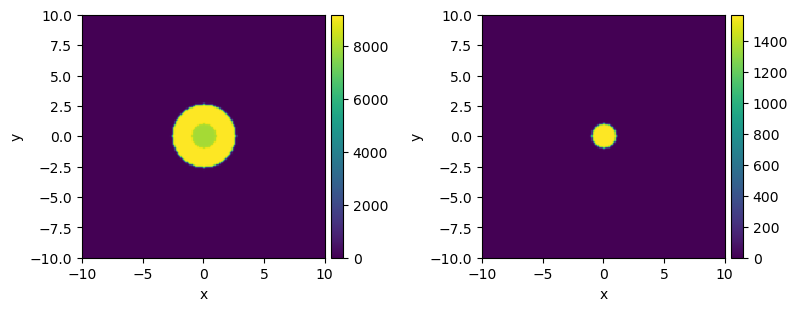

In [10]:
import pde
from pde.grids.cartesian import CartesianGrid
from pde.pdes.base import PDEBase
from pde.fields.collection import FieldCollection
from pde.fields.scalar import ScalarField
from pde.fields.vectorial import VectorField


# delta = 0.05 # mm
# tau = 0.2 # h
# Du = Di = 1.88e-4 # mm^2/h
# beta = 1.02e-1 # h-1
# p	= 1.87e-2 # h-1
# q	= 4.17e-2 # h-1
# P = K	= 1e3 # 1/mm^2
# Ru = 2.6 # mm
# Ri = 1 # mm

class MorselliPDE(PDEBase):
    """FitzHugh–Nagumo model with diffusive coupling"""

    def __init__(self, Du=Du, Di=Di, p=p, beta=beta, K=K, q=q, Ru=Ru, Ri=Ri, bc="auto_periodic_neumann"):
        super().__init__()
        self.bc = bc
        self.Du = Du
        self.Di = Di
        self.p = p
        self.beta = beta
        self.K = K
        self.q = q
        self.Ru = Ru
        self.Ri = Ri


    def evolution_rate(self, state, t=0):
        u, i = state
        u_t = self.Du*u.laplace(bc=self.bc) + self.p*u*(1-(u+i)/self.K) - (self.beta/self.K)*u*i
        i_t = self.Di*i.laplace(bc=self.bc) + (self.beta/self.K)*u*i - self.q*i

        return FieldCollection([u_t, i_t])


grid = CartesianGrid(((-10, 10),(-10, 10)), (size, size))
result = FieldCollection([ScalarField(grid, domain[0]), ScalarField(grid, domain[1])])

# print(state[0].data)
eq = MorselliPDE()

# for i in range(1,101):
for i in range(1,2):
  print(f"hour {i*10}")
  result = eq.solve(result, t_range=10, dt=0.01)
  # np.save(f"{SIM_FOLDER}/results/pde_random_2d_h{10*i}.npy", result.data)
  result.plot()
